Онлайн-гипермаркет «Утконос» – это сервис доставки продуктов нового поколения, совмещающий традиционные и современные технологии розничной торговли. Утконос был создан в 2000 году и на данный момент является одним из лидеров e-grocery на российском рынке.

**Задача**, которую нам нужно решить - прогнозирование вероятности отказа клиента от заказа без учета времени и стадии формирования заказа.

Подключаем нужные нам для работы библиотеки, скачиваем датасет:

In [1]:
import pandas as pd
import numpy as np
import datetime
import glob
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

Снизу небольшая таблица о том, какие у нас есть данные:

|              	|                                      Данные                                     	|
|:------------:	|:-------------------------------------------------------------------------------:	|
| Date         	| Плановая дата доставки до клиента                                               	|
| DateOrder    	| Дата оформления заказа                                                          	|
| ClientID     	| ID клиента                                                                      	|
| ChannelID    	| ID канала сбыта                                                                 	|
| OrderID      	| ID заказа, присваиваемый сайтом                                                 	|
| MaterialID   	| ID материала                                                                    	|
| DeliveryType 	| Тип доставки                                                                    	|
| Cluster      	| Кластер доставки                                                                	|
| Interval     	| Временной интервал доставки (с/до)                                              	|
| CancelFlag   	| Метка отмены заказов(целевая переменная для первого этапа)                      	|
| OrderCnt     	| Количество заказанных предметов                                                 	|
| Prepay       	| Признак предоплаты                                                              	|
| Count_edit   	| Число редактирований заказа клиентом, значение "1" означает первоначальный ввод 	|

Первым делом загрузим данные из .csv файла :

In [2]:
data = pd.read_csv('train.csv', encoding='cp1251', low_memory=False)

Теперь ознакомимся с данными:

In [3]:
data.head(15)

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
0,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328810.0,61.0,NaN,0,1.0,Обычная доставка,0,1
1,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3281258.0,30.0,NaN,0,2.0,Обычная доставка,0,1
2,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3210734.0,10.0,NaN,0,1.0,Обычная доставка,0,1
3,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328848.0,61.0,NaN,0,2.0,Обычная доставка,0,1
4,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347801.0,17.0,NaN,0,10.0,Обычная доставка,0,1
5,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3044324.0,11.0,NaN,0,6.0,Обычная доставка,0,1
6,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347802.0,17.0,NaN,0,7.0,Обычная доставка,0,1
7,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3076533.0,63.0,NaN,0,4.0,Обычная доставка,0,1
8,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3155553.0,23.0,NaN,0,1.0,Обычная доставка,0,1
9,19-21.,05/10/2018,05/10/2018,93696397,2,90102092000,3344245.0,5.0,NaN,0,1.0,Доставка День в День,0,1


Немного изменим данные для дальнейшей работы - удалим столбец ClientID, т.к информация в нем не влияет на отказ от заказа, также поправим Interval, чтобы было удобнее обрабатывать:

In [4]:
data = data.drop(['ClientID'], axis=1)
tmp = data['Interval'].str.split('-')
data['int0']=tmp.apply(lambda x: int(x[0]))
data['int1']=tmp.apply(lambda x: int(x[1][:-1]))
del data['Interval']

Взглянем, сколько времени в днях длилась доставка от момента заказа до выдачи:

In [5]:
orderDate = data.OrderDate.apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
date = data.Date.apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
data['delivery_days'] = (date-orderDate).dt.days.astype(int).values

In [6]:
data['delivery_days'].head(10)

0    1
1    1
2    1
3    1
4    2
5    2
6    2
7    2
8    2
9    0
Name: delivery_days, dtype: int32

Теперь поманипулируем датой: создадим переменную *orderDay* для того, чтобы в ней хранился день заказа
Также, создадим переменную *day*, тут будет информация о дне, когда заказ был отмененён или доставлен
После этого, удалим *data['Date']* и *data['OrderDate']* , т.к. точная дата заказа никак не влияет на закономерность, что впринципе было и указано в задаче

In [7]:
orderDay = data['OrderDate'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').weekday())
day = data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').weekday())
data['orderDay'] = orderDay
data['day'] = day

del data['Date']
del data['OrderDate']

Еще немного поработаем на интервалами (это мы по-джентльменски позаимствовали у нашего товарища), сперва найдем середины интервалов, дабы определить время суток, в которое был совершен заказ

In [8]:
interval_low = data['int0']
interval_high = data['int1']
interval_avg = (interval_high + interval_low) / 2

Теперь разобьем время на 4 интервала: утро, день, вечер и ночь

In [9]:
morning = list(range(6, 12))
day = list(range(12, 18))
evening = list(range(18, 24))
night = [24] + list(range(1, 6))

morning = interval_avg.isin(morning)
day = interval_avg.isin(day)
evening = interval_avg.isin(evening)
night = interval_avg.isin(night)

data['interval_low'] = interval_low
data['interval_high'] = interval_high
data['interval_avg'] = interval_avg
data['morning'] = morning.apply(lambda x: 1 if x else 0)
data['dayTime'] = day.apply(lambda x: 1 if x else 0)
data['evening'] = evening.apply(lambda x: 1 if x else 0)
data['night'] = night.apply(lambda x: 1 if x else 0)

Теперь надо понять в какой день недели был сделан заказ, а также необходимо сократить количество редактирований заказа на 1, чтобы избавиться от значения "1", которое обозначает только первоначальный ввод

In [10]:
data['is_order_weekend'] = data['orderDay'].apply(lambda x: 1 if x in [5,6] else 0)
data['is_weekend'] = data['day'].apply(lambda x: 1 if x in [5,6] else 0)
data['count_edit'] -= 1

Последним стоит поменять качественный признак DeliveryType на количественный:

In [12]:
data['DeliveryType'] = data['DeliveryType'].map({'Обычная доставка': 0, 'Доставка День в День': 1})

Посмотрим баланс выборки и как распределены данные по нашему критерию:

In [14]:
data.groupby('CancelFlag').count()

,ChannelID,OrderID,MaterialID,GroupID,Cluster,OrderCnt,DeliveryType,prepay,count_edit,int0,...,day,interval_low,interval_high,interval_avg,morning,dayTime,evening,night,is_order_weekend,is_weekend
CancelFlag,,,,,,,,,,,,,,,,,,,,,
0,8519074,8519074,8518991,8518991,3168524,8518991,8519074,8519074,8519074,8519074,...,8519074,8519074,8519074,8519074,8519074,8519074,8519074,8519074,8519074,8519074
1,504110,504110,504088,504088,182592,504088,504110,504110,504110,504110,...,504110,504110,504110,504110,504110,504110,504110,504110,504110,504110


Выведем данные о наших данных :)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9023184 entries, 0 to 9023183
Data columns (total 24 columns):
ChannelID           int64
OrderID             int64
MaterialID          float64
GroupID             float64
Cluster             object
CancelFlag          int64
OrderCnt            float64
DeliveryType        int64
prepay              int64
count_edit          int64
int0                int64
int1                int64
delivery_days       int32
orderDay            int64
day                 int64
interval_low        int64
interval_high       int64
interval_avg        float64
morning             int64
dayTime             int64
evening             int64
night               int64
is_order_weekend    int64
is_weekend          int64
dtypes: float64(4), int32(1), int64(18), object(1)
memory usage: 1.6+ GB


### Дисперсия

Импортируем еще пару библиотек для бивариантного анализа, а также сразу найдем дисперсию данных для выдвижения гипотезы о том, как влияют данные о *типе доставки*, *длительности доставки*, *предоплате*, *времени суток* и *количестве редактирований заказа* на отмену заказа

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
data[['CancelFlag', 'DeliveryType', 'delivery_days', 
           'prepay', 'morning', 'dayTime', 'evening', 'night', 'count_edit', 'is_order_weekend', 'is_weekend']].groupby('CancelFlag').var()

,DeliveryType,delivery_days,prepay,morning,dayTime,evening,night,count_edit,is_order_weekend,is_weekend
CancelFlag,,,,,,,,,,
0,0.022959,0.233153,0.162488,0.234013,0.230098,0.183114,0.003225,17.152443,0.195696,0.210585
1,0.016801,0.452698,0.063171,0.232487,0.229998,0.176597,0.006069,24.137897,0.192930,0.208717


По дисперсии мы видим, что все признаки, кроме времени суток и выходных дней, довольно значительно влияют на отмену заказа

### Бивариантный анализ

Корреляция – связь между двумя метрическими переменными. При построении корреляции, мы ищем признаки, зависимые друг от друга или каким-либо образом влияющие на значения друг друга. Коэффициент корреляции признака с самим собой всегда равен единице, это значение не должно учитываться при исследовании зависимостей. Удобное представление коэффициентов корреляции - тепловая карта, представленная ниже. Но нам интересна в данном случае лишь зависимость между CancelFlag и остальными признаками

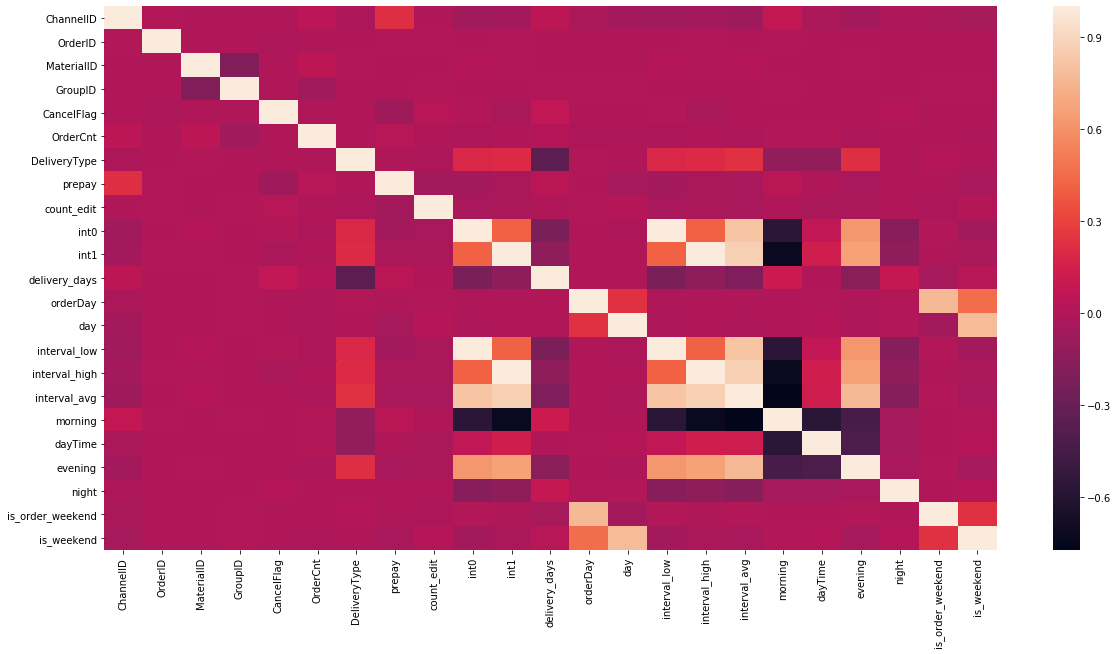

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr())

### Круговые диаграммы

Здесь мы построим 2 круговые диаграммы - зависимость отказа от дней недели и зависимость отмены от предоплаты

Разобьем данные по дням недели:

In [20]:
monday = data.orderDay.apply(lambda x: 1 if x==0 else 0)
tuesday = data.orderDay.apply(lambda x: 1 if x==1 else 0)
wednesday = data.orderDay.apply(lambda x: 1 if x==2 else 0)
thursday = data.orderDay.apply(lambda x: 1 if x==3 else 0)
friday = data.orderDay.apply(lambda x: 1 if x==4 else 0)
saturday = data.orderDay.apply(lambda x: 1 if x==5 else 0)
sunday = data.orderDay.apply(lambda x: 1 if x==6 else 0)

data['monday'] = monday
data['tuesday'] = tuesday
data['wednesday'] = wednesday
data['thursday'] = thursday
data['friday'] = friday
data['saturday'] = saturday
data['sunday'] = sunday

>Обязательно нужно найти отношение отмененных заказов ко всем заказам по дням недели

In [21]:
cancel_data = data[['CancelFlag', 'monday', 'tuesday', 'wednesday', 'thursday',
           'friday', 'saturday', 'sunday']].groupby('CancelFlag').sum()
size1 = cancel_data.values[1]
size2 = cancel_data.values[0]
proportion=size1/(size1+size2)

После этого строим нашу первую диаграмму:

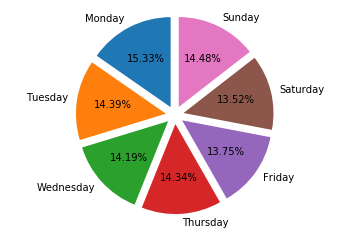

In [25]:
labels = 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) 
fig1, ax1 = plt.subplots()

ax1.pie(proportion*100, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

По диаграмме видно, что понедельник и воскресенье в большей мере влияют на отмену заказа, нежели остальные дни недели
***
Теперь же построим диаграмму зависимости предоплаты и отмены заказа. 


Для начала посчитаем кол-во всех отмененных заказов с предоплатой:

In [26]:
cancelPrepay = data[['CancelFlag', 'prepay']].groupby('CancelFlag').count()['prepay']
print(cancelPrepay)

CancelFlag
0    8519074
1     504110
Name: prepay, dtype: int64


Строим диаграмму:

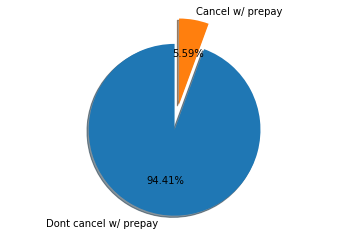

In [28]:
labels = 'Dont cancel w/ prepay', 'Cancel w/ prepay'
explode = (0, 0.3)  

fig1, ax1 = plt.subplots()
ax1.pie(cancelPrepay, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

Очевидно, что с предоплатой кол-во отказов минимально

### Столбчатая диаграмма

Здесь построим столбчатую диаграмму зависимости отказов от кол-ва дней доставки, т.е. от времени, сколько пришлось ждать человеку

Перед построением диаграммы импортируем недостающую библиотеку и посчитаем отношение отмененных заказов по времени ожидания ко всем заказам

In [32]:
cancelled = data[['CancelFlag', 'delivery_days']].groupby('delivery_days').sum()['CancelFlag']
all_orders = data[['CancelFlag', 'delivery_days']].groupby('delivery_days').count()['CancelFlag']
cancelled_proportion = cancelled/all_orders

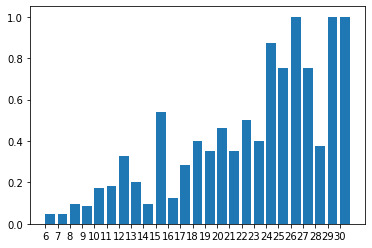

In [34]:
import numpy as np
cancelled_proportion_values = cancelled_proportion[cancelled_proportion.index >= 0]

s = cancelled_proportion_values
x = range(len(s))
ax = plt.gca()
ax.bar(x, s, align='edge')
ax.set_xticks(x)
ax.set_xticklabels((cancelled_proportion.index+10))
plt.show()

Прекрасно видно, что чем больше дней ожидания, тем выше влияние на отказ
___
Перед переходом к дальнейшему анализу стоит сохранить наши измененные данные:

In [35]:
data.to_csv('dataRefactor.csv', index=False)
data = pd.read_csv('dataRefactor.csv', encoding='cp1251', low_memory=False)

Заполним пустые строки медианой значений, удалим пустые строчки:

In [36]:
data.dropna()
data = data.fillna(data.median(axis=0), axis=0)

Подготовим тестовую и тренировочную выборки:

In [39]:
from sklearn.model_selection import train_test_split
X = data[['OrderCnt', 'DeliveryType', 'prepay', 'count_edit',
       'int0', 'int1', 'delivery_days', 'orderDay']]
y = data.values[::, 5]
y = y.astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.7)

---
### Decision Tree Classifier

***Это метод поддержки принятия решений, основанный на использовании древовидного графа: модели принятия решений, которая учитывает их потенциальные последствия (с расчётом вероятности наступления того или иного события), эффективность, ресурсозатратность. Для бизнес-процессов это дерево складывается из минимального числа вопросов, предполагающих однозначный ответ — «да» или «нет». Последовательно дав ответы на все эти вопросы, мы приходим к правильному выбору. Методологические преимущества дерева принятия решений – в том, что оно структурирует и систематизирует проблему, а итоговое решение принимается на основе логических выводов. Решающее дерево- покрывающий набор конъюнкций. Требование максимизации информативности конъюнкций означает, что каждая из них должна выделять как можно больше обучающих объектов, допуская при этом как можно меньше ошибок. Для повышения обобщающей способности решающего дерева число листьев должно быть как можно меньше, и они должны покрывать подвыборки примерно одинаковой мощности.***


***Матрица ошибок (confusion matrix) — это способ разбить объекты на четыре категории в зависимости от комбинации истинного ответа и ответа алгоритма. Основные термины: TP — истино-положительное решение; TN — истино-отрицательное решение; FP — ложно-положительное решение (Ошибка первого рода); FN — ложно-отрицательное решение (Ошибка второго рода).
$$\begin{equation*}
\frac{TP+TN}{{P + N}} =\frac{TP+TN}{{TP + TN +FP +FN}}
\end{equation*}$$Данная мeтрика имеет существенный недостаток — её значение необходимо оценивать в контексте баланса классов. Это означает, что доля положительных ответов сама по себе не несет никакой информации о качестве работы алгоритма a(x), и вместе с ней следует анализировать соотношение классов в выборке.Гораздо более информативными критериями являются точность (precision) и полнота (recall). Точность показывает, какая доля объектов, выделенных классификатором как положительные, действительно является положительными:
$$\begin{equation*}
Precision =\frac{TP}{{TP + FP}}
\end{equation*}$$Полнота показывает, какая часть положительных объектов была выделена классификатором***
$$\begin{equation*}
Recall =\frac{TP}{{TP + FN}}
\end{equation*}$$
---

Импортируем нужные библиотеки для построения модели:

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Строим дерево и матрицу ошибок:

In [45]:
model = DecisionTreeClassifier(max_depth=8,random_state=4, criterion='gini',min_samples_leaf=2)
model.fit(X_train,Y_train)
model.predict(X_test)
model.predict(X_train)
print(confusion_matrix(Y_test,model.predict(X_test)))
print("Confusion matrix for train model")
print(confusion_matrix(Y_train,model.predict(X_train)))
print('\nGini classifier')
print('test data')
print(accuracy_score(Y_test,model.predict(X_test)))
print("train data")
print(accuracy_score(Y_train,model.predict(X_train)))

print('\nEntropy classifier')
model2 = DecisionTreeClassifier(max_depth=8,random_state=4, criterion='entropy',min_samples_leaf=2)
model2.fit(X_train,Y_train)
model2.predict(X_test)
model2.predict(X_train)
print('test data')
print(accuracy_score(Y_test,model2.predict(X_test)))
print("train data")
print(accuracy_score(Y_train,model2.predict(X_train)))

[[5961791    1383]
 [ 348615    4440]]
Confusion matrix for train model
[[2555318     582]
 [ 149079    1976]]

Gini classifier
test data
0.9445875062477944
train data
0.944712416719155

Entropy classifier
test data
0.9446038134462826
train data
0.9447183274195544


Можно заметить, что с модель с энтропийной классификацией дает чуть более высокие результаты
___

Выведем оба дерева:

[Text(185.30878378378378, 205.35999999999999, 'X[2] <= 0.5\nentropy = 0.311\nsamples = 2706955\nvalue = [2555900, 151055]'),
 Text(110.06047297297296, 181.2, 'X[6] <= 1.5\nentropy = 0.346\nsamples = 2175863\nvalue = [2034993, 140870]'),
 Text(58.06216216216216, 157.04, 'X[3] <= 5.5\nentropy = 0.313\nsamples = 1849628\nvalue = [1745498, 104130]'),
 Text(31.04189189189189, 132.88, 'X[5] <= 9.0\nentropy = 0.308\nsamples = 1774013\nvalue = [1676098, 97915]'),
 Text(16.086486486486486, 108.72, 'X[3] <= 2.5\nentropy = 0.355\nsamples = 206734\nvalue = [192868, 13866]'),
 Text(8.043243243243243, 84.56, 'X[7] <= 5.5\nentropy = 0.35\nsamples = 199091\nvalue = [185996, 13095]'),
 Text(4.021621621621621, 60.400000000000006, 'X[0] <= 1.5\nentropy = 0.345\nsamples = 171533\nvalue = [160456, 11077]'),
 Text(2.0108108108108107, 36.24000000000001, 'X[4] <= 3.0\nentropy = 0.352\nsamples = 118267\nvalue = [110412, 7855]'),
 Text(1.0054054054054054, 12.079999999999984, 'entropy = 0.518\nsamples = 448\nval

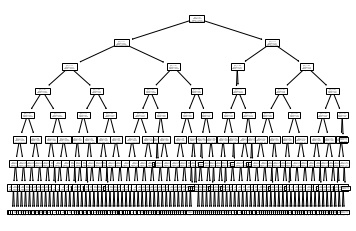

In [46]:
from sklearn import tree
tree.plot_tree(model.fit(X_train, Y_train))
tree.plot_tree(model2.fit(X_train, Y_train))

Также, нужно построить ROC-кривую:

*ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (англ. false positive rate, FPR) при варьировании порога решающего правила. Количественную интерпретацию ROC даёт показатель AUC (англ. area under ROC curve, площадь под ROC-кривой) — площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию).*

Импортируем нужные библиотеки:

In [48]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

Рисуем нашу кривую:

In [52]:
pred_proba = model.predict_proba(X_test)

0.6380625245334907


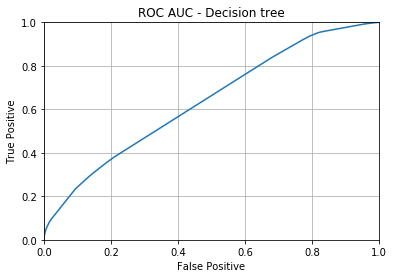

In [59]:
#fpr - false positive rate, tpr - true positive rate
fpr, tpr, thresholds = roc_curve(Y_test,pred_proba[:,1])
print(roc_auc_score(Y_test,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("ROC AUC - Decision tree")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

### Random Forest Classifier

***Random forest (с англ. — «случайный лес») — алгоритм машинного обучения, предложенный Лео Брейманом и Адель Катлер, заключающийся в использовании комитета (ансамбля) решающих деревьев. Алгоритм сочетает в себе две основные идеи: метод бэггинга Бреймана, и метод случайных подпространств, предложенный Tin Kam Ho. Алгоритм применяется для задач классификации, регрессии и кластеризации. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим.***

Импортируем библиотеку для построения модели:

In [56]:
from sklearn.ensemble import RandomForestClassifier

Строим нашу модель и матрицу ошибок:

In [61]:
model = RandomForestClassifier(n_estimators=100,
                               max_depth=12,
                               random_state=4,
                               oob_score=True,
                               n_jobs=-1)
model.fit(X_train,Y_train)
model.predict(X_test)
model.predict(X_train)
print(confusion_matrix(Y_test,model.predict(X_test)))
print('test data')
print(accuracy_score(Y_test,model.predict(X_test)))
print("Confusion matrix of train model")
print(confusion_matrix(Y_train,model.predict(X_train)))
print("train data")
print(accuracy_score(Y_train,model.predict(X_train)))

[[5962902     272]
 [ 347696    5359]]
test data
0.9449089005480961
Confusion matrix of train model
[[2555825      75]
 [ 148627    2428]]
train data
0.9450666893243516


Строим ROC-кривую для нашей модели:

0.6574538511647715


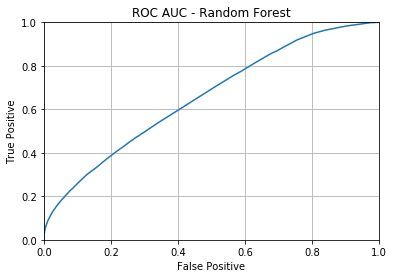

In [63]:
pred_proba = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test,pred_proba[:,1])
print(roc_auc_score(Y_test,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("ROC AUC - Random Forest")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

### Bagging

***Бэггинг (баггинг) - от англ. Bootstrap aggregating, это технология классификации, использующая композиции алгоритмов, каждый из которых обучается независимо. Результат классификации определяется путем голосования. Бэггинг позволяет снизить процент ошибки классификации в случае, когда высока дисперсия ошибки базового метода. Бэггинг – технология классификации, где все элементарные классификаторы обучаются и работают параллельно (независимо друг от друга). Идея заключается в том, что классификаторы не исправляют ошибки друг друга, а компенсируют их при "голосовании". Базовые классификаторы должны быть независимыми, это могут быть классификаторы основанные на разных группах методов или же обученные на независимых наборах данных.***

Импортируем нужные нам библиотеки:

In [62]:
from sklearn.ensemble import BaggingClassifier

Строим модель и матрицу ошибок:

In [64]:
b_model = BaggingClassifier()
b_model.fit(X_train,Y_train)
b_model.predict(X_test)
b_model.predict(X_train)
print(confusion_matrix(Y_test,b_model.predict(X_test)))
print('test data')
print(accuracy_score(Y_test,b_model.predict(X_test)))
print("Confusion matrix of train model")
print(confusion_matrix(Y_train,b_model.predict(X_train)))
print("train data")
print(accuracy_score(Y_train,b_model.predict(X_train)))

[[5956443    6731]
 [ 334444   18611]]
test data
0.9459843840367409
Confusion matrix of train model
[[2554304    1596]
 [ 141988    9067]]
train data
0.94695737461465


Строим ROC-кривую для нашей модели:

0.676369622757166


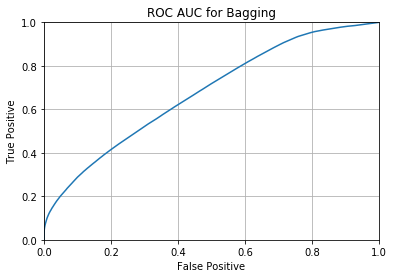

In [66]:
pred_proba = b_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test,pred_proba[:,1])
print(roc_auc_score(Y_test,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("ROC AUC for Bagging")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

### AdaBoost

***Алгоритм AdaBoost (сокр. от adaptive boosting) — алгоритм машинного обучения, предложенный Йоавом Фройндом (Yoav Freund) и Робертом Шапиром (Robert Schapire). Является мета-алгоритмом, в процессе обучения строит композицию из базовых алгоритмов обучения для улучшения их эффективности. AdaBoost является алгоритмом адаптивного бустинга в том смысле, что каждый следующий классификатор строится по объектам, которые плохо классифицируются предыдущими классификаторами. AdaBoost вызывает слабый классификатор в цикле. После каждого вызова обновляется распределение весов, которые отвечают важности каждого из объектов обучающего множества для классификации. На каждой итерации веса каждого неверно классифицированного объекта возрастают, таким образом новый классификатор «фокусирует своё внимание» на этих объектах. Алгоритм может использоваться в сочетании с несколькими алгоритмами классификации для улучшения их эффективности. Алгоритм усиливает классификаторы.***

Импортируем библиотеку:

In [67]:
from sklearn.ensemble import AdaBoostClassifier

Строим модель:

In [69]:
abc = AdaBoostClassifier(b_model,
                         algorithm="SAMME",
                         n_estimators=1)

abc.fit(X_train, Y_train)
y_pred = abc.predict(X_test)

print(accuracy_score(Y_test, y_pred))

0.9459764679209699


Строим ROC-кривую для нашей модели:

0.6763988554061438


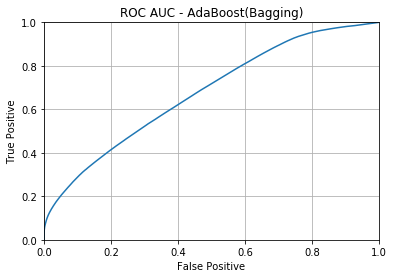

In [71]:
pred_proba = abc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test,pred_proba[:,1])
print(roc_auc_score(Y_test,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("ROC AUC - AdaBoost(Bagging)")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

## Выводы

Поместим все результаты в таблицу:

| Название классификатора 	|     Результаты     	|
|:-------------:	|:------------------:	|
| **Decision Tree** 	| 0.6380625245334907 	|
| **Random Forest** 	| 0.6574538511647715 	|
| **Bagging**     	| 0.676369622757166  	|
| **AdaBoost**      	| 0.6763988554061438 	|

Лучшая оценка, которую мы получили оказалась на методе AdaBoost, который почти не улучшил результаты метода Bagging.
В итоге работы не были применены некоторые методы обработки данных, такие как one hot encoding.

Таким образом, изучив различные методы тренировки модели, а также применив их - у нас получилась модель, которая дает ответ с ошибкой ~33%, что является не самым лучшим результатом, но в качестве опыта работы над моделями - вышло достаточно неплохо. Возможно, если бы создавались уникальные признаки для каждого уникального значения, то модель могла выйти более точной.